In [1]:
#Dataset
from keras.datasets import cifar10
#Modelo
from keras.models import Sequential
#Camadas 
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
#Atributos da rede
from keras import optimizers, losses, regularizers
#Ferramentas uteis
from keras.utils import to_categorical
#Data Augmentation
from keras.preprocessing.image import ImageDataGenerator
#Predição
from random import randint
import matplotlib.pyplot as plt
from numpy import argmax
#Carrrega uma rede ja treinada
from keras.models import load_model
###Bibliotecas da SOM

#Self Organizing Map
from minisom import MiniSom

import matplotlib.pyplot as plt
import numpy as np
import pickle
from keras import models
import random

2024-08-09 14:15:51.195605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


X TRAIN:  (50000, 32, 32, 3)
Y TRAIN:  (50000, 10)
X TEST:  (10000, 32, 32, 3)
Y TEST:  (10000, 10)


2024-08-07 20:44:33.713793: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_2 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                      

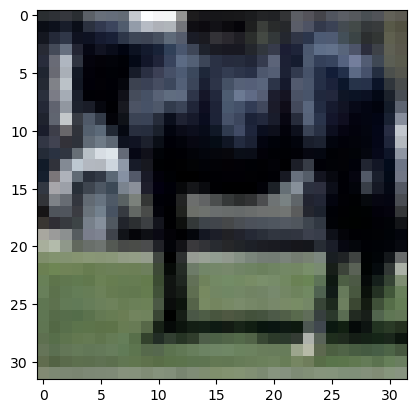

In [2]:
batch_size = 100
epochs = 5
num_classes = 10
decay = 1e-3
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255
x_test = x_test/255
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print('X TRAIN: ',x_train.shape)
print('Y TRAIN: ',y_train.shape)
print('X TEST: ',x_test.shape)
print('Y TEST: ',y_test.shape)

model = load_model('../../../networks/CNN_37_CIFAR10.h5')

'''
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l1_l2(decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l1_l2(decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l1_l2(decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l1_l2(decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l1_l2(decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l1_l2(decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(1000, activation='sigmoid'))
model.add(Dropout(0.3))

model.add(Dense(500, activation='sigmoid'))

model.add(Dense(100, activation='sigmoid'))
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation='softmax'))
'''
model.summary()

'''

optimizer = optimizers.rmsprop(lr=0.001, decay=1e-6)
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=1, fill_mode='nearest', horizontal_flip=True, vertical_flip=True)
datagen.fit(x_train)
model.fit_generator(datagen.flow(x_train, y_train, batch_size), epochs=epochs, validation_data=(x_test, y_test), shuffle=True, steps_per_epoch=len(x_train)/batch_size, workers=1)
#model.fit(x_train, y_train, batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True)

'''
#score = model.evaluate(x_test, y_test, verbose=1)
#print("Test score: ", score[0])
#print("Test accuracy: ", score[1])


i = randint(1, x_test.shape[0])
pred = x_test[i].reshape(1, x_test.shape[1], x_test.shape[2], x_test.shape[3])
prediction = model.predict(pred)
print(classes[argmax(y_test[i])],  "------>", classes[argmax(prediction)])
plt.imshow(pred.reshape(x_test.shape[1:]))

In [3]:
###FUNCOES E OPERACOES REFERENTES AO TRATAMENTO DOS DADOS ANTES DO SOM

#Imprime os nomes das camadas do modelo
j = 0
for i in model.layers:
    print(j, ' - ', i.name)
    j += 1

#Define um elemento com os outputs
layer_outputs = [layer.output for layer in model.layers[1:] ]
#Cria um modelo que retorna os outputs de cada camada dados os inputs do modelo
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 

#Função que retorna o feature vector de uma determinada camada, dada uma imagem
def get_layer(model, image, layer_num):
    out = []
    layer_outputs = [layer.output for layer in model.layers[1:] ]
    # Extracts the outputs of the top 12 layers

    activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
    # Creates a model that will return these outputs, given the model input

    layer = activation_model.predict(image, verbose=0)
    layer = layer[layer_num]
    layer = layer.reshape(np.prod(layer.shape))
    out.append(layer)
    return out

data = np.concatenate((x_train, x_test))
labels = np.concatenate((y_train, y_test))
data.shape

0  -  conv2d_1
1  -  activation_1
2  -  batch_normalization_1
3  -  conv2d_2
4  -  activation_2
5  -  batch_normalization_2
6  -  max_pooling2d_1
7  -  dropout_1
8  -  conv2d_3
9  -  activation_3
10  -  batch_normalization_3
11  -  conv2d_4
12  -  activation_4
13  -  batch_normalization_4
14  -  max_pooling2d_2
15  -  dropout_2
16  -  conv2d_5
17  -  activation_5
18  -  batch_normalization_5
19  -  conv2d_6
20  -  activation_6
21  -  batch_normalization_6
22  -  max_pooling2d_3
23  -  dropout_3
24  -  flatten_1
25  -  dense_1
26  -  dropout_4
27  -  dense_2
28  -  dense_3
29  -  dropout_5
30  -  dense_4


(60000, 32, 32, 3)

In [4]:
##CRIAÇÃO E TREINAMENTO DO SOM

#Cria um SOM com 'num_el' elementos na entrada e a saída um mapa de dim x dim
dim = 15
num_el = 500
som = MiniSom(dim, dim, num_el, sigma=3, learning_rate=0.05)
print('OK')

#Passa os n primeiros elementos do dataset pela rede, pega o feature_vector de uma camada layer
n = 5000
layer = 26
cont = 0
for image in data[:n]:
    image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    image = get_layer(model, image, layer);
    som.train(image, 1, verbose=False);
    print(f'\r\r\r{cont}/{n}\t\t', end = '')
    cont+=1

OK


2/5000		WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f52cc77ca60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/5000		WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f52cca19940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, 

In [5]:

#Nome: som_'dimensao do mapa'_'numero de exemplos treinados'_'camada da qual veio a entrada'.p
# saving the som in the file som.p
with open('som_15_5k_26_CIFAR10.p', 'wb') as outfile:
    pickle.dump(som, outfile)
    
    
model.save('CNN_77_FashionMNIST.h5')


In [ ]:
# layer2 = 14
# with open('../../../networks/som_40_5k_14_CIFAR10.p', 'rb') as infile:
#     som2: MiniSom = pickle.load(infile)

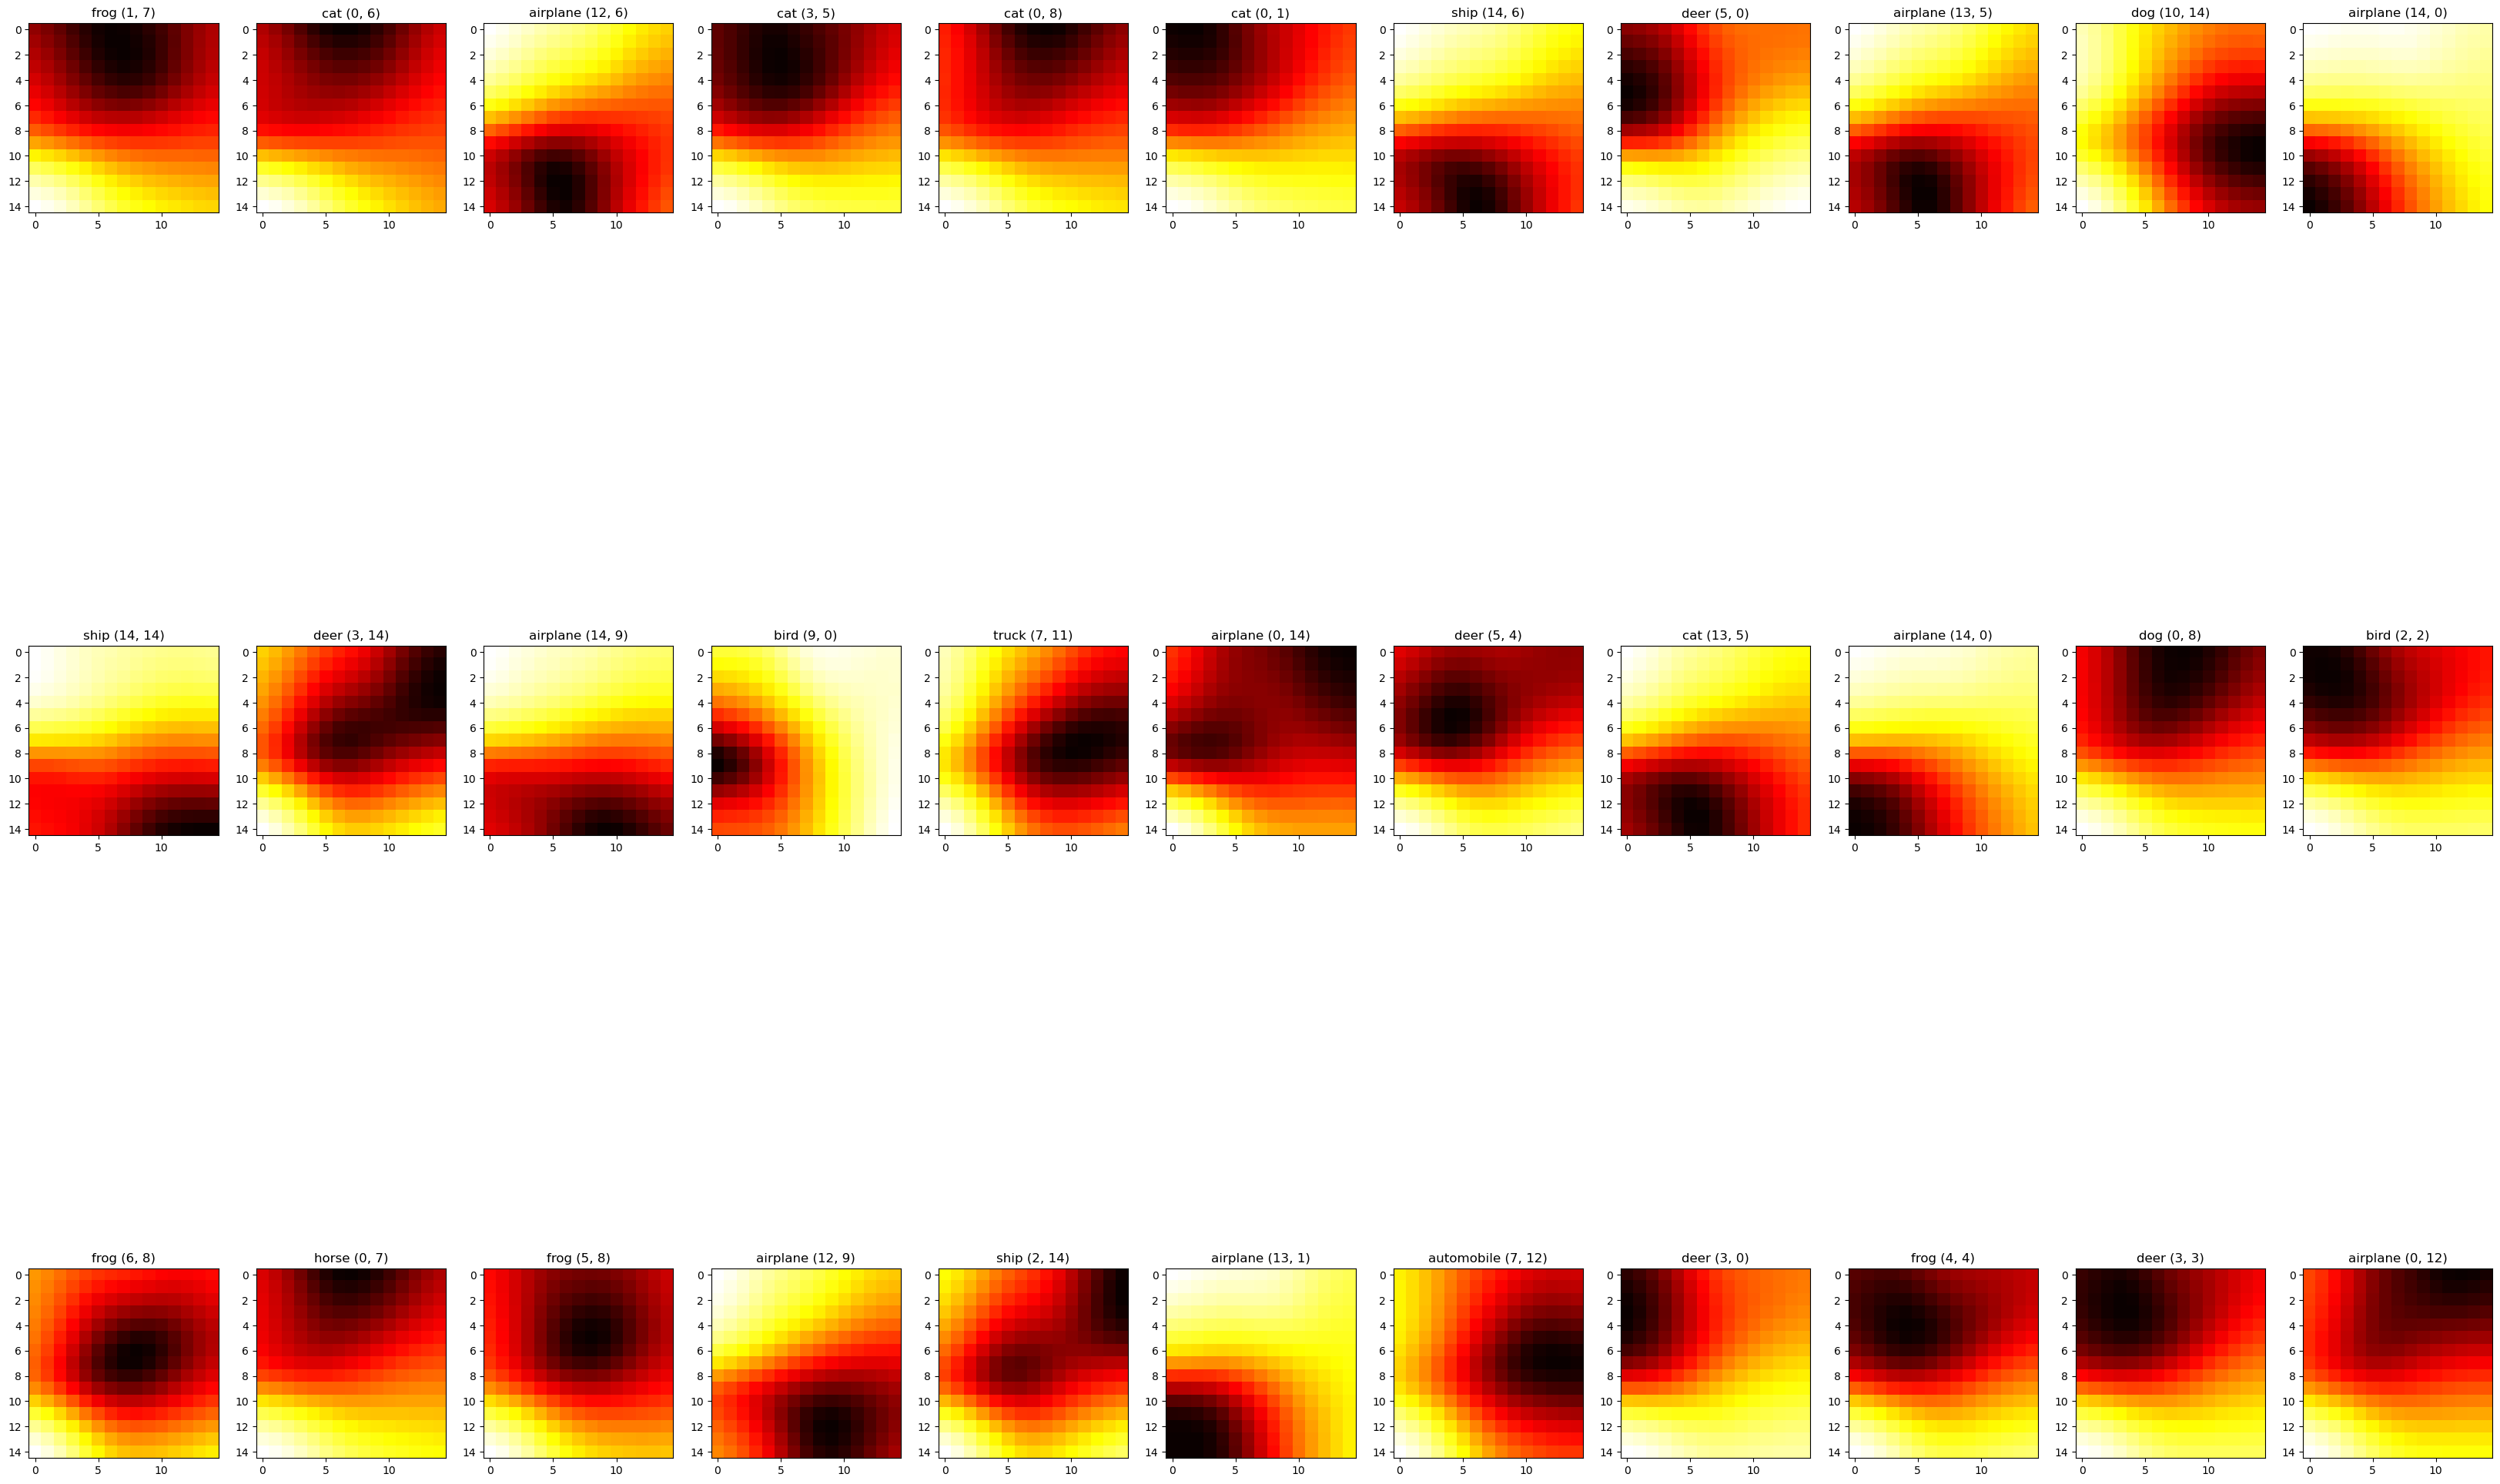

In [9]:
j=1
tests = []
out_som1 = []
num_ex = 33
for i in range(num_ex):
    n = random.randint(50000, 60000)
    tests.append(n)
    teste = data[n].reshape(1, data.shape[1], data.shape[2], data.shape[3])
    img = get_layer(model, teste, layer)
    teste = 1 - som.activate(img)
    out_som1.append(teste)
    plt.subplot(len(teste), 11, j)
    plt.imshow(teste, cmap='hot')
    label = classes[argmax(labels[n])]+" "+str(som.winner(img))
    j+=1
    plt.title(label)
plt.subplots_adjust(left=0, bottom=0, right=5, top=25, wspace=0.2, hspace=0.2)
plt.show()

In [10]:
j=1
out_som2 = []
for n in tests:
    teste = data[n].reshape(1, data.shape[1], data.shape[2], data.shape[3])
    l_out = get_layer(model, teste, layer2)
    teste = som.activate(l_out)
    out_som2.append(teste)
    plt.subplot(len(teste), 11, j)
    plt.imshow(teste, cmap='hot')
    label = classes[argmax(labels[n])]+" "+som.winner(l_out)

    j+=1
    plt.title(label)
plt.subplots_adjust(left=0, bottom=0, right=5, top=25, wspace=0.2, hspace=0.2)
plt.show()

1/1 [==============================] - 0s 281ms/step


AttributeError: 'MiniSom' object has no attribute '_activation_distance'

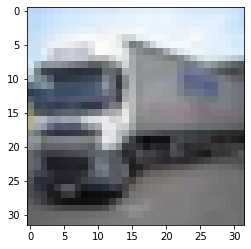

In [59]:
plt.imshow(data[n])

In [173]:
# Import Independent Component Analysis Algorithm
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
#--------------------------------------------------------------------------------------------------
def layerPooling(feature_map, pooling_type = "max"):
    #Alterar os feature maps para cada elemento ser uma camada de ativacoes da CNN: (1, x, x, y) ----> (1, y, x, x)
    init_shape = np.shape(feature_map)
    new_map = []
    for i in range(int(init_shape[3])):
        aux = np.empty((init_shape[1], init_shape[2]))
        for j in range(int(init_shape[2])):
            for k in range(int(init_shape[1])):
                aux[k][j] = layer[0][k][j][i]
        new_map.append(aux)  
    new_map = [new_map]
    
    new_map_red = []
    for conv_map in new_map[0]:
        aux = np.empty((int(conv_map.shape[0]/2), int(conv_map.shape[1]/2)))
        l=0
        for i in range(0, conv_map.shape[0], 2):
            c=0
            for j in range(0, conv_map.shape[1], 2):
                if(pooling_type == 'max'):
                    aux[l][c] = max(conv_map[i][j], conv_map[i+1][j], conv_map[i][j+1], conv_map[i+1][j+1])
                elif(pooling_type == 'mean'):
                    aux[l][c] = (conv_map[i][j] + conv_map[i+1][j] + conv_map[i][j+1] + conv_map[i+1][j+1])/4
                c+=1
            l+=1 
        new_map_red.append(aux)
    new_map_red = [new_map_red]
    return new_map, new_map_red

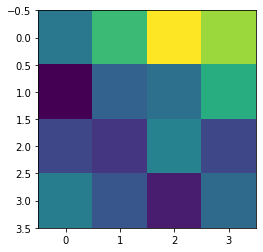

In [193]:
layer_outputs = model.layers[14].output 
# Extracts the outputs of the top 12 layers

activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
# Creates a model that will return these outputs, given the model input
n=6795
img = data[n].reshape(1, data[n].shape[0], data[n].shape[1], data[n].shape[2])
layer = activation_model.predict(img)
#print(np.shape(layer))
#layer = layerPCA(layer, 16)
#print(np.shape(layer))

or_layer, layer = layerPooling(layer, pooling_type = 'max')

#new_map = np.reshape(new_map, (init_shape[0], init_shape[3], init_shape[1], init_shape[2]))
#print(np.shape(layer))
plt.imshow(layer[0][50])

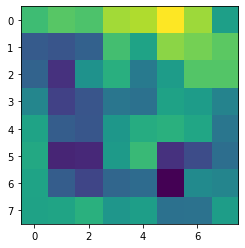

In [194]:
plt.imshow(or_layer[0][50])

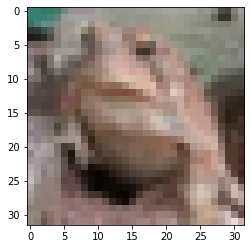

In [195]:
plt.imshow(data[n])

In [ ]:
def layerPooling(feature_map, pooling_type = "max"):
    init_shape = np.shape(feature_map)
    aux = np.empty((init_shape[1], init_shape[2]))
    new_map = []
    for i in range(int(init_shape[3])):
        for j in range(int(init_shape[2])):
            for k in range(int(init_shape[1])):
                aux[k][j] = feature_map[0][k][j][i]
        new_map.append(aux)  
    mult_shape = int(sqrt(np.shape(feature_map)[-1]))
    while ((np.shape(feature_map)[-1])%mult_shape != 0):
        mult_shape += 1
    feature_map = feature_map.reshape((int(np.shape(feature_map)[1]*mult_shape), int(np.shape(feature_map)[2]*(np.shape(feature_map)[-1]/mult_shape))))
    feature_map_red = np.empty((int(feature_map.shape[0]/2), int(feature_map.shape[1]/2)))
    l=0
    for i in range(0, feature_map.shape[0], 2):
        c=0
        for j in range(0, feature_map.shape[1], 2):
            if(pooling_type == 'max'):
                feature_map_red[l][c] = max(feature_map[i][j], feature_map[i+1][j], feature_map[i][j+1], feature_map[i+1][j+1])
            elif(pooling_type == 'mean'):
                feature_map_red[l][c] = (feature_map[i][j] + feature_map[i+1][j] + feature_map[i][j+1] + feature_map[i+1][j+1])/4
            c+=1
        l+=1 
    return feature_map_red  